# Classifying stars

Processed and balanced data obtained from [Kaggle](https://www.kaggle.com/vinesmsuic/star-categorization-giants-and-dwarfs)

I will used this data set to test out the XGBoost classifier. Information on the dataset is as follows:

        Stellar Classification uses the spectral data of stars to categorize them 
        into different categories.
        
        The modern stellar classification system is known as the Morgan–Keenan (MK)
        classification system. It uses the old HR classification system to categorize
        stars with their chromaticity and uses Roman numerals to categorize the star’s
        size.
        
        In this Dataset, we will be using Absolute Magnitude and B-V Color Index to
        Identify Giants and Dwarfs (`TargetClass`).

Classifying stars based on their `TargetClass` as being either:
- Star is a Dwarf (0)
- Star is a Giant (1)

Note: This is a good dataset for learning about XGBoost, but it is not a good problem to solve with XGBoost as the number of features are relatively small and the problem is a simple binary classification problem.

In [34]:
#load libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as pyplot
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


In [9]:
#read in zip file

star_df = pd.read_csv('data/Star39552_balanced.csv.zip')

# Quick EDA

In [10]:
star_df.describe(include='all')

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
count,39552.000000,39552.000000,39552.000000,39552.000000,39552,39552.000000,39552.000000
unique,NaN,NaN,NaN,NaN,2576,NaN,NaN
top,NaN,NaN,NaN,NaN,K0III,NaN,NaN
freq,NaN,NaN,NaN,NaN,2841,NaN,NaN
mean,7.921309,7.117378,1.109705,0.744336,NaN,16.050687,0.500000
std,1.308857,12.446291,0.788133,0.513987,NaN,2.443937,0.500006
min,-0.620000,-27.840000,0.420000,-0.400000,NaN,-0.350000,0.000000
25%,7.210000,2.430000,0.800000,0.358000,NaN,14.756514,0.000000
50%,8.160000,4.440000,0.990000,0.703000,NaN,16.020827,0.500000
75%,8.830000,8.232500,1.230000,1.129000,NaN,17.590542,1.000000


All numeric apart from `SPtype` and `TargetClass` (which is numeric but only 0 or 1)

In [11]:
#check missing
star_df.isnull().sum()

Vmag           0
Plx            0
e_Plx          0
B-V            0
SpType         0
Amag           0
TargetClass    0
dtype: int64

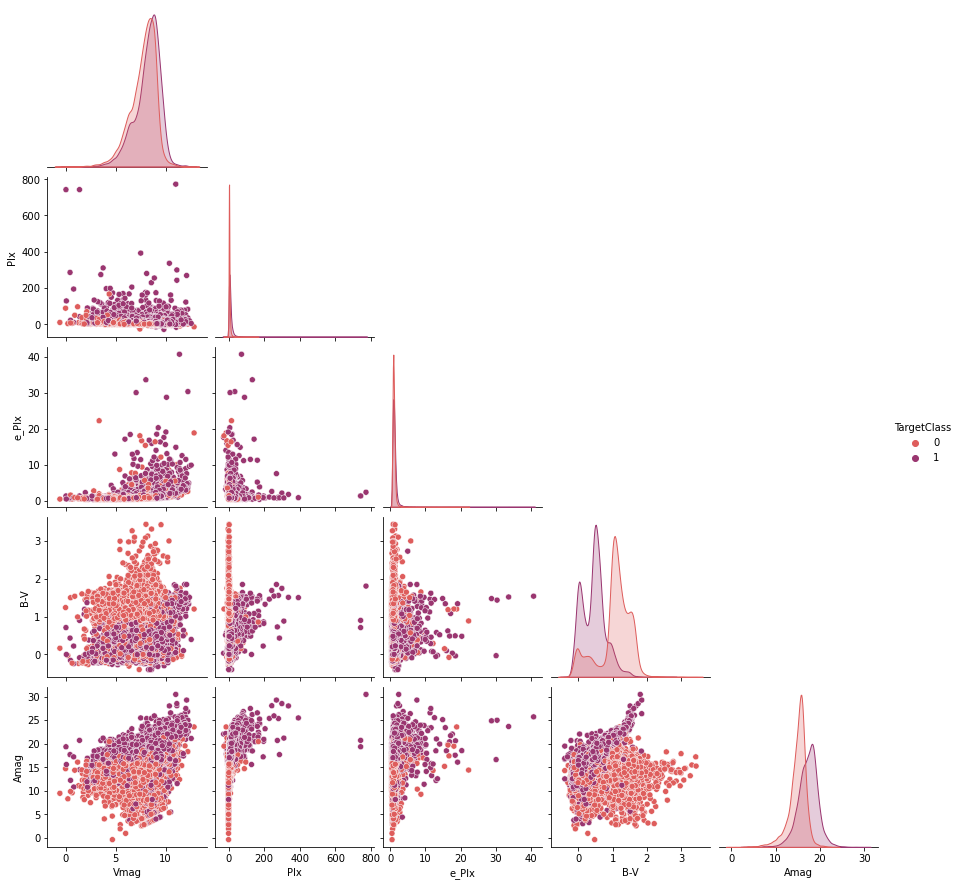

In [16]:
# pairs plot to have a look at the data
sns.pairplot(star_df,
hue = 'TargetClass',
palette = 'flare',
corner = True)

Pix and e_Pix look like they could do with being log transformed.

B-V is binomial for `TargetClass`= 1 (giants)

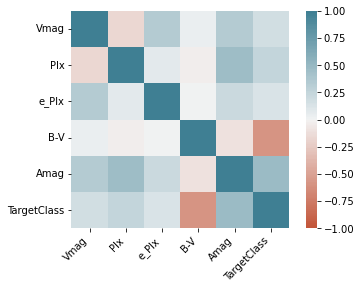

In [20]:
corr = star_df.corr()
corr_plot = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
corr_plot.set_xticklabels(
    corr_plot.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

`B-V` and `TargetClass` are strongly negatively correlated. Other correlations appear fairly weak.

# Create test train split

In [22]:
X = star_df.drop('TargetClass', axis=1)
y = star_df.TargetClass

In [26]:
# list of predictor names for later labelling
X_names = list(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now prepare categorical columns for One-hot Encoding.

In [32]:
# sort categorical columns from numeric
cat = (X_train.dtypes == 'object')
cat_cols = list(cat[cat].index)


['SpType']


# Start building the pipeline

In [36]:
# create one-hot encoder transformer

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse='False'))
])

# create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols)
    ])

## First model - Dummy classifier

In [48]:
# define initial dummy model
dummy_model = DummyClassifier(random_state=42)

In [49]:
dummy_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('model', dummy_model)])


In [50]:
# run the dummy pipeline
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse='False'))]),
                                                  ['SpType'])])),
                ('model', DummyClassifier(random_state=42))])

In [51]:
# get model metrics
print("Training Accuracy", (dummy_pipe.score(X_train, y_train)) * 100)
print("Test Accuracy", (dummy_pipe.score(X_test, y_test)) * 100)

y_pred_test = dummy_pipe.predict(X_test)
y_pred_train = dummy_pipe.predict(X_train)

print("MAE train", mean_absolute_error(y_train.astype('int'),
                                        y_pred_train.astype('int')))
print("MAE test", mean_absolute_error(y_test.astype('int'),
                                         y_pred_test.astype('int')))

print("AUC train", roc_auc_score(y_train, y_pred_train))
print("AUC test", roc_auc_score(y_test, y_pred_test))



Training Accuracy 50.26705856325654
Test Accuracy 48.93186702060422
MAE train 0.49732941436743466
MAE test 0.5106813297939578
AUC train 0.5
AUC test 0.5


As expected, the dummy classifier is no better than 50/50 guess!

## Second model - Random Forest

Note - This model is for comparision with XGBoost. 
If I were training a random methodically, could use cross-validation (i.e. `GridSearchCV`) to maximise AUC and tune the hyper-parameters to determine the optimal value from the search grid.

Three parameters are important to tweak to avoid overfitting a random forest:

* `n_estimators` - more trees reduces overfitting
* `max_depth` - the deeper the tree the more the risk of overfitting
* `min_samples_leaves` - the smaller the number of training exmples in the leave the greater the risk of overfitting

In [ ]:
#use default settings for random forest
rf_model = RandomForestClassifier(random_state=42)